In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

data = pd.read_csv('/content/DataSet_perishable.csv', parse_dates=True)

data = data.dropna()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15402 entries, 0 to 15401
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order Date     15402 non-null  object
 1   Customer Name  15402 non-null  object
 2   Sub Category   15402 non-null  object
 3   Sales          15402 non-null  int64 
 4   Expiry Date    15402 non-null  object
 5   City           15402 non-null  object
 6   Region         15402 non-null  object
dtypes: int64(1), object(6)
memory usage: 842.4+ KB


,Order Date,Customer Name,Sub Category,Sales,Expiry Date,City,Region
0,2015-01-01,Meera Krishnamurthy,Breads & Buns,151,2015-01-03,Lucknow,Central
1,2015-01-01,Priya Patel,Organic Vegetables,69,2015-01-06,Jhansi,West
2,2015-01-01,Lakshmi Nair,Fish,38,2015-01-02,Chitrakut,South
3,2015-01-01,Amit Kumar,Mutton,38,2015-01-02,Mirzapur,South
4,2015-01-01,Nitin Hegde,Chicken,189,2015-01-02,Prayagraj,South


# Step 1: Aggregate data to monthly

In [17]:

data['Order Date'] = pd.to_datetime(data['Order Date'])  # Ensure datetime format
data.set_index('Order Date', inplace=True)
monthly_data = data.resample('ME')['Sales'].sum().reset_index()
monthly_data.rename(columns={'Sales': 'Monthly_Sales'}, inplace=True)

# Step 2: Feature engineering

In [18]:

monthly_data['Month'] = monthly_data['Order Date'].dt.month
monthly_data['Year'] = monthly_data['Order Date'].dt.year
monthly_data['Lag_1'] = monthly_data['Monthly_Sales'].shift(1)  # Previous month's sales
monthly_data['Lag_2'] = monthly_data['Monthly_Sales'].shift(2)  # Two months ago

# Drop NaN rows caused by lag features
monthly_data.dropna(inplace=True)

# Step 3: Split the data

In [19]:


X = monthly_data[['Month', 'Year', 'Lag_1', 'Lag_2']]
y = monthly_data['Monthly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the model using Random Forest with hyperparameter tuning

In [20]:

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42)

In [21]:
# Step 5: Make predictions
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)


In [22]:
# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)*100
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Model Performance:
Mean Absolute Error (MAE): 2159.284285714286
Mean Squared Error (MSE): 6434185.2616428565
R² Score: 0.6843809169473558
Mean Absolute Percentage Error (MAPE): 13.85951495241894


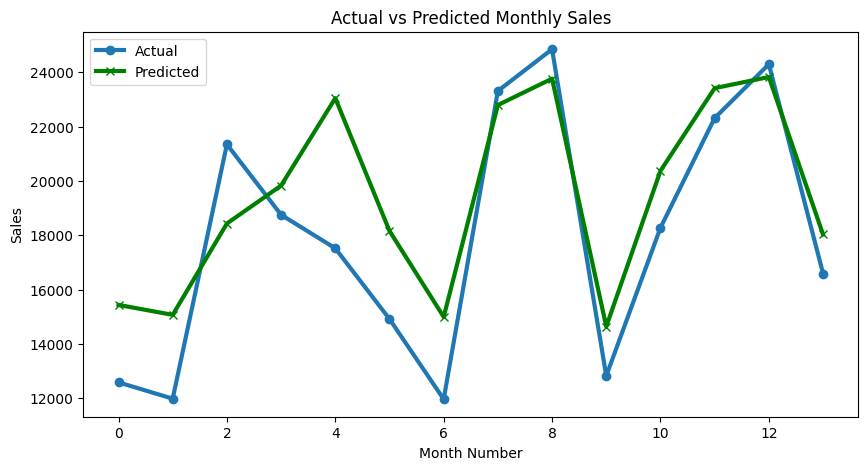

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o', lw=3)
plt.plot(y_pred, label='Predicted', marker='x', lw=3, color = 'green')
plt.xlabel('Month Number')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs Predicted Monthly Sales')
plt.show()


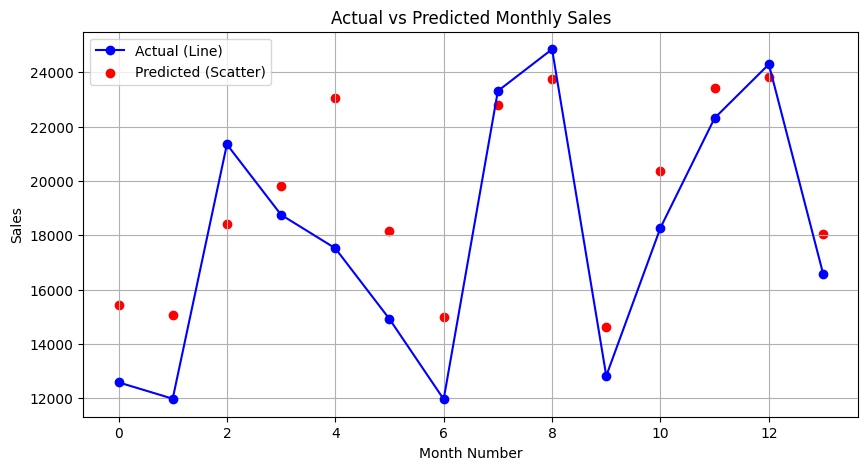

In [24]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual (Line)', marker='o', linestyle='-', color='blue')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted (Scatter)', color='red')
plt.title('Actual vs Predicted Monthly Sales')
plt.ylabel('Sales')
plt.xlabel('Month Number')
plt.legend()
plt.grid(True)
plt.show()

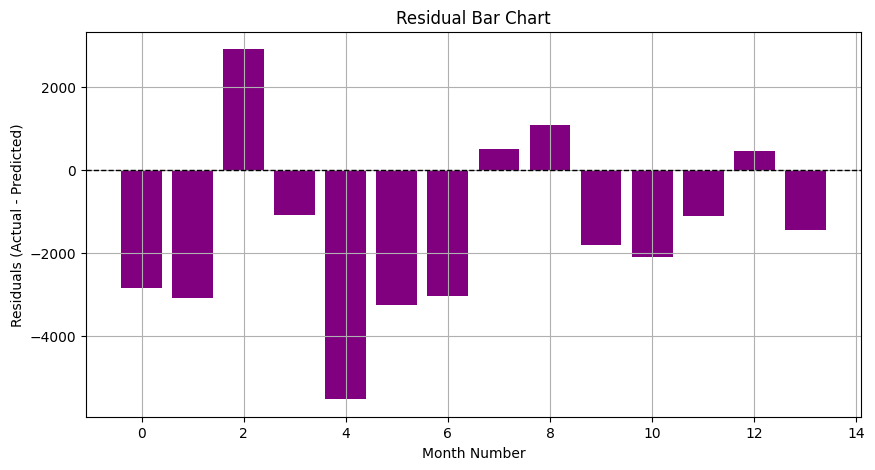

In [25]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residual bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(residuals)), residuals, color='purple')
plt.title('Residual Bar Chart')
plt.xlabel('Month Number')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Zero error line
plt.grid(True)
plt.show()


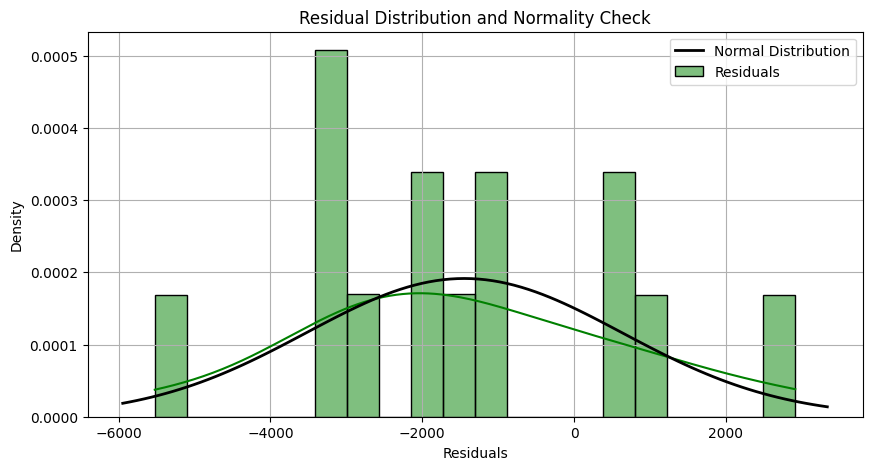

In [26]:
import seaborn as sns
from scipy.stats import norm

# Plot histogram of residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='green', stat='density', bins=20, label='Residuals')

# Overlay normal distribution curve
mu, std = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Residual Distribution and Normality Check')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import matplotlib.pyplot as plt

# Step 1: Prepare future dates
last_date = monthly_data['Order Date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                             periods=24,
                             freq='ME')  # Next 2 years of monthly data

future_df = pd.DataFrame({'Order Date': future_dates})
future_df['Month'] = future_df['Order Date'].dt.month
future_df['Year'] = future_df['Order Date'].dt.year

# Step 2: Adding lag features based on the last known data
future_df['Lag_1'] = monthly_data['Monthly_Sales'].iloc[-1]  # Last month's sales
future_df['Lag_2'] = monthly_data['Monthly_Sales'].iloc[-2]  # Two months ago


<ipython-input-28-ea0a7d99df67>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_total = data.resample('M')['Sales'].sum()


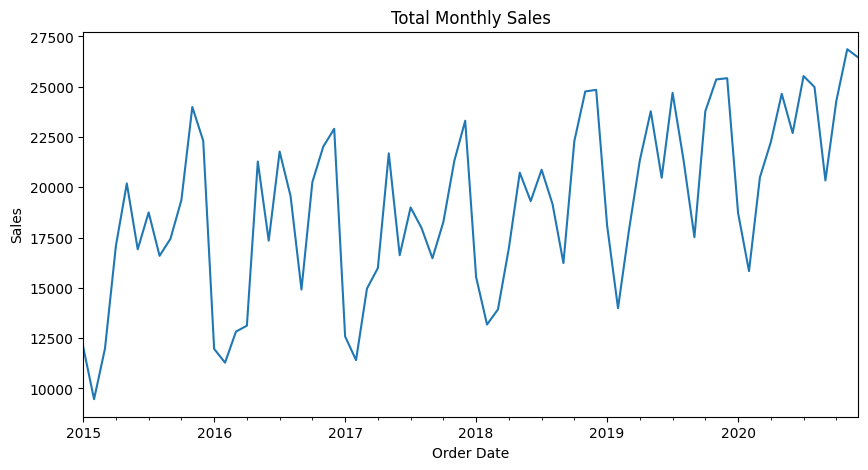

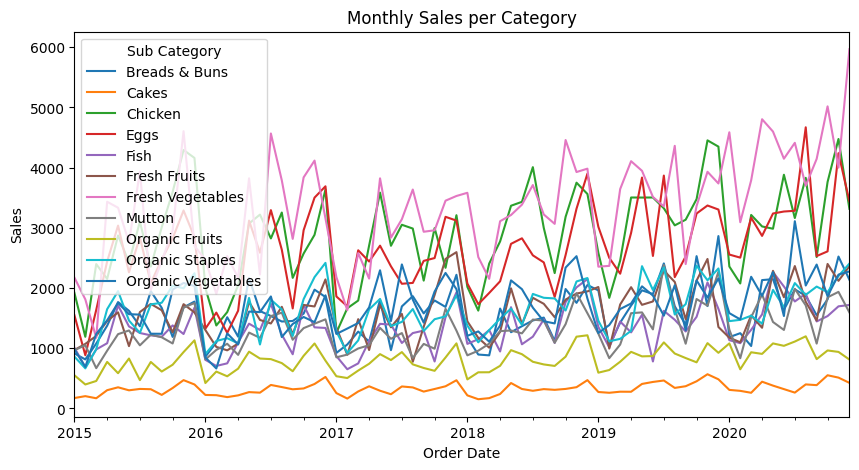

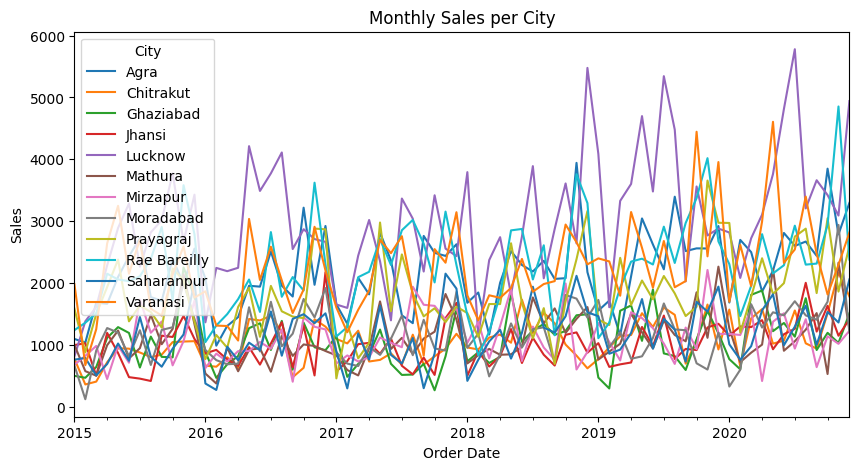

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


data.index = pd.to_datetime(data.index, errors='coerce')

# Plot Total Monthly Sales
monthly_sales_total = data.resample('M')['Sales'].sum()
monthly_sales_total.plot(title='Total Monthly Sales', figsize=(10, 5))
plt.ylabel('Sales')
plt.show()

# Plot Monthly Sales per Category
monthly_sales_category = data.groupby([data.index.to_period('M'), 'Sub Category'])['Sales'].sum().unstack()
monthly_sales_category.plot(title='Monthly Sales per Category', figsize=(10, 5))
plt.ylabel('Sales')
plt.show()

# Plot Monthly Sales per City
monthly_sales_city = data.groupby([data.index.to_period('M'), 'City'])['Sales'].sum().unstack()
monthly_sales_city.plot(title='Monthly Sales per City', figsize=(10, 5))
plt.ylabel('Sales')
plt.show()